[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

The use of transfer learning and fine-tuning has provided SOTA performances in the deep learning context. However, the more complex the models become, the more resource-intense the training process becomes too.  To speed up this process, this notebook, focused on image classification in the domain of agriculture, shows more simple transfer learning approach is considered. Using the pre-trained CNN features as input for an ensemble method. This approach was denominated as top-tuning in [1]. 

In [ ]:
!pip install -q timm

#### Library Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
import timm
from tqdm import tqdm

/home/beast/anaconda3/envs/eden_pytorch_transfer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Auxiliar functions
Check the docstrings for more information.

In [2]:
def create_basic_file_structure():
    '''
    It creates the basic folder structure to further use PyTorch Data loader functionalities.
    '''
    if not os.path.exists(ROOT_FOLDER_NAME):
        os.makedirs(ROOT_FOLDER_NAME)
        os.makedirs(ROOT_FOLDER_NAME + os.path.sep + TRAIN_FOLDER_NAME)
        os.makedirs(ROOT_FOLDER_NAME + os.path.sep + VALIDATION_FOLDER_NAME)
        print("Directories Created ")
    else:    
        print("Directory " , ROOT_FOLDER_NAME ,  " already exists")

In [3]:
def create_complete_file_structure():
    '''
    It creates the basic folder structure to further use PyTorch Data loader functionalities.
    Moreover, given the folder where the datasets are stores, it creates a train-validation split
    of the data.
    WARNING: Modify the experimental constants provided below to create a different file structure.
    '''
    TRAIN_VAL_SPLIT = 0.75
    
    create_basic_file_structure()
    for dataset_foder_name in DATASET_FOLDER_NAMES:
        print(f"Copying: {dataset_foder_name}")
        print(dataset_foder_name.split("-")[0])
        label_name = dataset_foder_name.split("-")[0]
        new_image_train_path = ROOT_FOLDER_NAME + os.path.sep + \
                                TRAIN_FOLDER_NAME + os.path.sep + label_name
        new_image_val_path = ROOT_FOLDER_NAME + os.path.sep + \
                                VALIDATION_FOLDER_NAME + os.path.sep + label_name
        os.makedirs(new_image_train_path)
        os.makedirs(new_image_val_path)
        original_complete_folder_path = ORIGINAL_DATASETS_FOLDER + os.path.sep + \
                                            dataset_foder_name
        original_images_files = os.listdir(original_complete_folder_path)
        len_dataset = len(original_images_files)
        print(f"Number of copied images:{len_dataset}")
        for image_file in original_images_files[:int(len_dataset*TRAIN_VAL_SPLIT)]:
            shutil.copyfile(original_complete_folder_path + os.path.sep + image_file, 
                            new_image_train_path + os.path.sep + image_file)
        for image_file in original_images_files[int(len_dataset*TRAIN_VAL_SPLIT):]:
            shutil.copyfile(original_complete_folder_path + os.path.sep + image_file, 
                            new_image_val_path + os.path.sep + image_file)

In [4]:
def get_class_names(image_datasets):
    '''
    Given the <image_datasets> data structure, it returns the names of the classes.

        Parameters:
            image_datasets (Dict[ImageFolder]): Pytorch data structure with the datasets info.

        Returns:
            class_names (List[String]): List containing the class of each image.
            processing.
    '''
    class_names = image_datasets['train'].classes
    return class_names

In [5]:
def get_image_datasets(data_path):
    '''
    Given the <data_path> where the data folders are stored, it returns a Pytorch-oriented
    data structure for further processing. Probably, DataLoader creation. 

        Parameters:
            data_path (string): The path where the folders are located.

        Returns:
            image_datasets (Dict[ImageFolder]): PyTorch Data Structure for further
            processing.
    '''
    # Data augmentation and normalization for training and validation
    # Depending on the Architectures evaluated the Resize + CenterCrop should change 
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # It depends on the archicture
            #transforms.ColorJitter(0.1, 0.1, 0.1, 0.1), # Experimental purposes
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # It depends on the archicture
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1), # Experimental purposes
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}

    return image_datasets

In [6]:
def imshow(dataloaders, class_names):
    '''
    Given the <dataloaders> and a list with the name of the classes <class_names>,
    it displays a grid of shuffled sample images.

        Parameters:
            dataloaders (DataLoader): PyTorch structure for managing images.
            class_names (List[String]): The list of class names per image.
    '''
    images, labels = next(iter(dataloaders['train']))
    rows = 4
    columns = 4
    fig = plt.figure(figsize=(10,10))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(16):
        fig.add_subplot(rows, columns, i+1)
        plt.title(class_names[labels[i]])
        img = images[i].numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.axis('off')
        plt.imshow(img)    
    plt.show()

In [8]:
def get_features(model, phase='train'):

    features = []
    labels  = []

    for image, label in tqdm(dataloaders[phase]):
        image = image.to(device)
        features.extend(model(image).detach().cpu().numpy())
        labels.extend(label.detach().numpy())
    features = np.array(features)

    return features, labels

#### Experimental Constants

In [9]:
BATCH_SIZE = 16
DATA_PATH = "./pytorch_eden_data"
NUM_WORKERS = 2

ROOT_FOLDER_NAME = "pytorch_eden_data"
ORIGINAL_DATASETS_FOLDER = os.path.dirname(os.getcwd()) + os.path.sep + \
                            "eden_library_datasets"
TRAIN_FOLDER_NAME = "train"
VALIDATION_FOLDER_NAME = "val"
DATASET_FOLDER_NAMES = ["Processing_tomato-Lycopersicum_esculentum-Healthy-PRX-RGB-NA-20200731/images",
                        "Tomato-Solanum_lycopersicum-Healthy-PRX-RGB-NA-20210607/images",
                        "Watermelon-Citrullus_lanatus-Healthy-PRX-RGB-NA-20210410/images",
                        "Cucumber-Cucumis_sativus-Healthy-PRX-RGB-NA-20210607/images"]

#### IMPORTANT: Run this command for automatically creating the folder structure.
**Warning**: Verify that the folders appearing in the varaible **DATASET_FOLDER_NAMES** are available inside your **eden_data** folder. In case you have any doubts, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

In [10]:
create_complete_file_structure()

Directories Created 
Copying: Processing_tomato-Lycopersicum_esculentum-Healthy-PRX-RGB-NA-20200731/images
Processing_tomato
Number of copied images:422
Copying: Tomato-Solanum_lycopersicum-Healthy-PRX-RGB-NA-20210607/images
Tomato
Number of copied images:186
Copying: Watermelon-Citrullus_lanatus-Healthy-PRX-RGB-NA-20210410/images
Watermelon
Number of copied images:147
Copying: Cucumber-Cucumis_sativus-Healthy-PRX-RGB-NA-20210607/images
Cucumber
Number of copied images:145


#### Loading images and Data Loaders

In [11]:
image_datasets = get_image_datasets(data_path=DATA_PATH)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'val']}

class_names = get_class_names(image_datasets)

#### Displaying some sample images

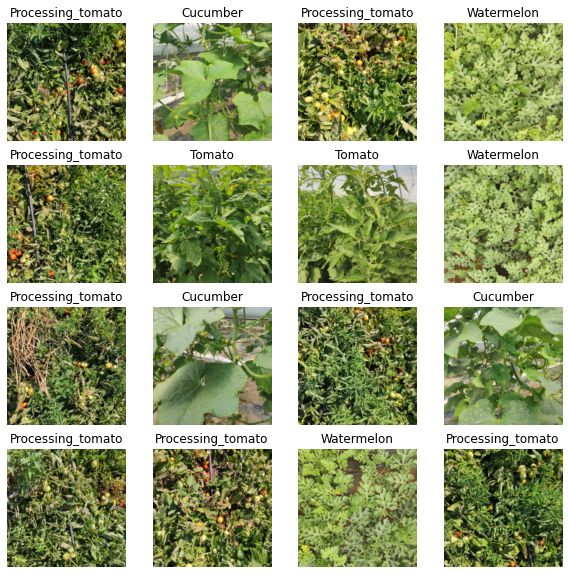

In [12]:
imshow(dataloaders, class_names)

#### Setting CUDA configuration if available

In [13]:
# Using CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### Training / Fine-Tuning Models
When using transfer learning, there are several strategies for reusing the weights or the knowledge learned on another task. Here 2 strategies are shown and compared:
1. **Feature Extraction**: The weights of the pre-trained architecture are not updated (the layers are frozen). This way, the architecture is used as a feature extractor while the last layer or classifier is trained to make sense of these features in the new problem.
2. **Fine-Tuning**: The weights of the pre-trained architecture are updated. The number of layers that are trained depends on the specific problem addressed and many times there is not a predefined best option.


In [14]:
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0, global_pool="avg")
model.to(device)
model.eval()
print()

In [15]:
train_features, train_labels = get_features(model, phase='train')
val_features, val_labels = get_features(model, phase='val')

100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(random_state=0)
clf.fit(train_features, train_labels)

RandomForestClassifier(random_state=0)

In [17]:
accuracy_score(clf.predict(val_features), val_labels)

0.9955947136563876

## Conclusions
As reported in [1], these results indicate that top-tuning provides a useful alternative to fine-tuning in small datasets, especially when training efficiency is crucial.

## Possible Extensions
1. Use a different pre-trained network from thos available on the timm library.
2. Try different ML algorithm on the top of the extracted features.

## Bibliography
[1] Alfano, P.D., Pastore, V.P., Rosasco, L., & Odone, F. (2022). Fine-tuning or top-tuning? Transfer learning with pretrained features and fast kernel methods. ArXiv, abs/2209.07932.